# Random Forest Model

This notebook implements and evaluates a Random Forest classifier for Alzheimer's disease prediction.

## Key Features:
- **Algorithm**: Random Forest ensemble method with multiple decision trees
- **Hyperparameter Tuning**: GridSearchCV with cross-validation
- **Feature Importance**: Built-in feature importance analysis
- **Evaluation**: Comprehensive metrics, confusion matrices, and ROC curves

## Model Overview:
Random Forest combines multiple decision trees using bootstrap sampling and random feature selection. This reduces overfitting and provides robust predictions with built-in feature importance rankings.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, ConfusionMatrixDisplay
)

## 1. Data Loading

Loading the preprocessed and split dataset from the preprocessing phase. The data includes:
- **Training set**: Used for model training and hyperparameter tuning
- **Validation set**: Used for model evaluation during development  
- **Test set**: Final evaluation on unseen data

All features have been preprocessed, encoded, and are ready for ML algorithms.

In [28]:
# Load preprocessed data
X_train = joblib.load('../outputs/preprocessed/X_train.pkl')
X_val = joblib.load('../outputs/preprocessed/X_val.pkl')
X_test = joblib.load('../outputs/preprocessed/X_test.pkl')
y_train = joblib.load('../outputs/preprocessed/y_train.pkl')
y_val = joblib.load('../outputs/preprocessed/y_val.pkl')
y_test = joblib.load('../outputs/preprocessed/y_test.pkl')

print("Data loaded successfully!")
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Data loaded successfully!
Train shape: (1944, 14)
Validation shape: (417, 14)
Test shape: (417, 14)


In [29]:
def evaluate_model(model, X_val, y_val, model_name="Model"):
    start_pred = time.time()
    y_pred = model.predict(X_val)
    end_pred = time.time()
    
    metrics = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, y_pred),
        "ROC-AUC": roc_auc_score(y_val, y_pred),
        "Prediction Time (s)": end_pred - start_pred
    }
    
    print(f"\n{model_name} Evaluation Results:")
    print(pd.DataFrame(metrics, index=[0]))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Alzheimer', 'Alzheimer'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_val, y_val)
    plt.title(f'{model_name} ROC Curve')
    plt.show()
    
    return y_pred, metrics

## 2. Training Phase - Random Forest Model

### Hyperparameter Tuning Strategy:
- **n_estimators**: Number of trees in the forest (100, 200) - more trees = better performance but longer training
- **max_depth**: Maximum depth of trees (10, 20, None) - controls overfitting vs underfitting
- **min_samples_split**: Minimum samples to split a node (2, 5) - prevents overfitting
- **min_samples_leaf**: Minimum samples in leaf nodes (1, 2) - smooths decision boundaries

### Random Forest Benefits:
1. **Ensemble Learning**: Combines predictions from multiple decision trees
2. **Feature Randomness**: Each tree uses random subset of features
3. **Bootstrap Sampling**: Each tree trained on random sample of data
4. **Built-in Feature Importance**: No separate analysis needed

GridSearchCV with 5-fold cross-validation finds the optimal combination.

In [30]:
# Random Forest with GridSearch
print("Training Random Forest with GridSearchCV...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

start_time = time.time()
rf_grid.fit(X_train, y_train)
end_time = time.time()

print(f"Training completed in {end_time - start_time:.2f} seconds")
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

# Get best model
best_rf = rf_grid.best_estimator_

Training Random Forest with GridSearchCV...
Training completed in 27.17 seconds
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9610
Training completed in 27.17 seconds
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9610



Random Forest (Validation) Evaluation Results:
   Accuracy  Precision    Recall  F1 Score   ROC-AUC  Prediction Time (s)
0  0.913669   0.948187  0.875598  0.910448  0.913761             0.034361

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92       208
           1       0.95      0.88      0.91       209

    accuracy                           0.91       417
   macro avg       0.92      0.91      0.91       417
weighted avg       0.92      0.91      0.91       417



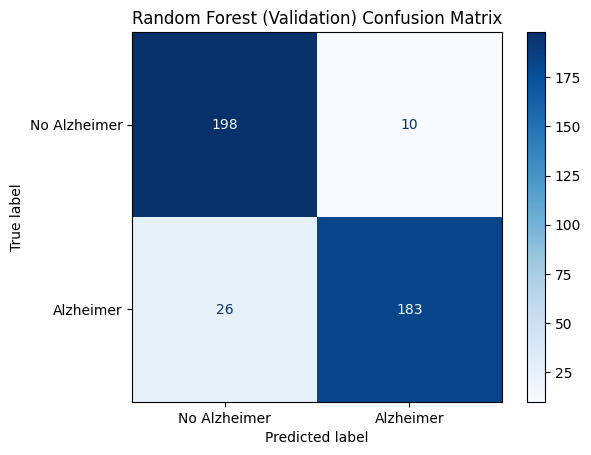

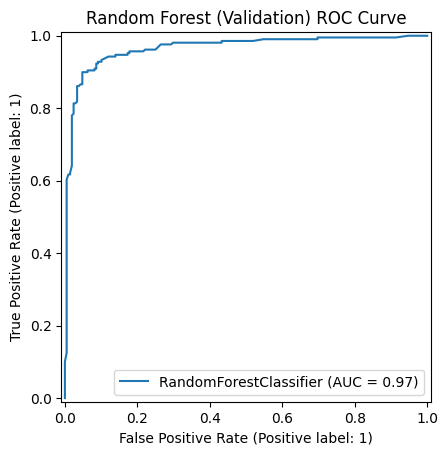

In [31]:
# Evaluate on validation set
y_pred_val, metrics_val = evaluate_model(best_rf, X_val, y_val, "Random Forest (Validation)")

## 3. Testing Phase - Random Forest Model

### Final Model Evaluation:
After selecting the best hyperparameters through cross-validation, we evaluate the model on the held-out test set to get unbiased performance estimates.

### Evaluation Metrics:
- **Accuracy**: Overall classification correctness
- **Precision**: Of predicted Alzheimer cases, how many are actually positive
- **Recall**: Of actual Alzheimer cases, how many were correctly identified  
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under the ROC curve, measures discrimination ability

### Visualization:
- **Confusion Matrix**: Shows true vs predicted classifications
- **ROC Curve**: Plots true positive rate vs false positive rate

In [32]:
# Test on test set
y_pred_test = best_rf.predict(X_test)
y_proba_test = best_rf.predict_proba(X_test)[:, 1]

print("Random Forest - Test Set Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_test))

print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

Random Forest - Test Set Results:
Accuracy: 0.920863309352518
Precision: 0.9533678756476683
Recall: 0.8846153846153846
F1 Score: 0.9177057356608479
ROC-AUC: 0.9567652741994846

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       209
           1       0.95      0.88      0.92       208

    accuracy                           0.92       417
   macro avg       0.92      0.92      0.92       417
weighted avg       0.92      0.92      0.92       417



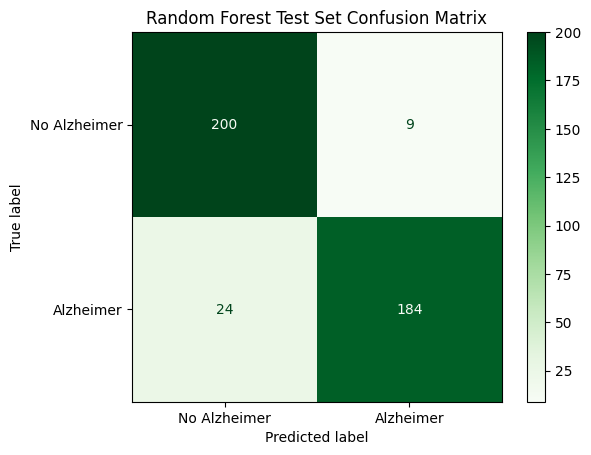

In [33]:
# Confusion Matrix for test set
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Alzheimer', 'Alzheimer'])
disp.plot(cmap='Greens', values_format='d')
plt.title('Random Forest Test Set Confusion Matrix')
plt.show()

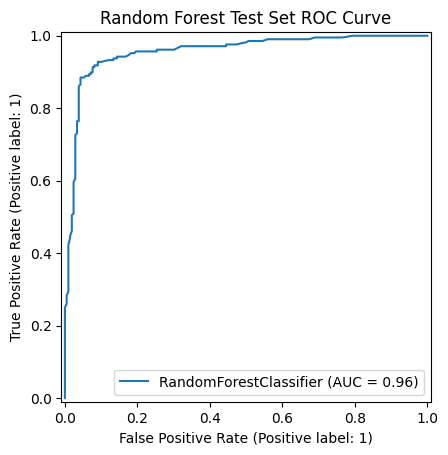

In [34]:
# ROC Curve for test set
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title('Random Forest Test Set ROC Curve')
plt.show()

### Feature Importance Analysis

Random Forest provides built-in feature importance based on how much each feature decreases impurity when used for splits across all trees. Higher importance values indicate more discriminative features for Alzheimer's prediction.

The top features represent the most influential clinical indicators in the classification decision.

C:\Users\Sana\AppData\Local\Temp\ipykernel_24176\450614880.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature', palette='viridis')


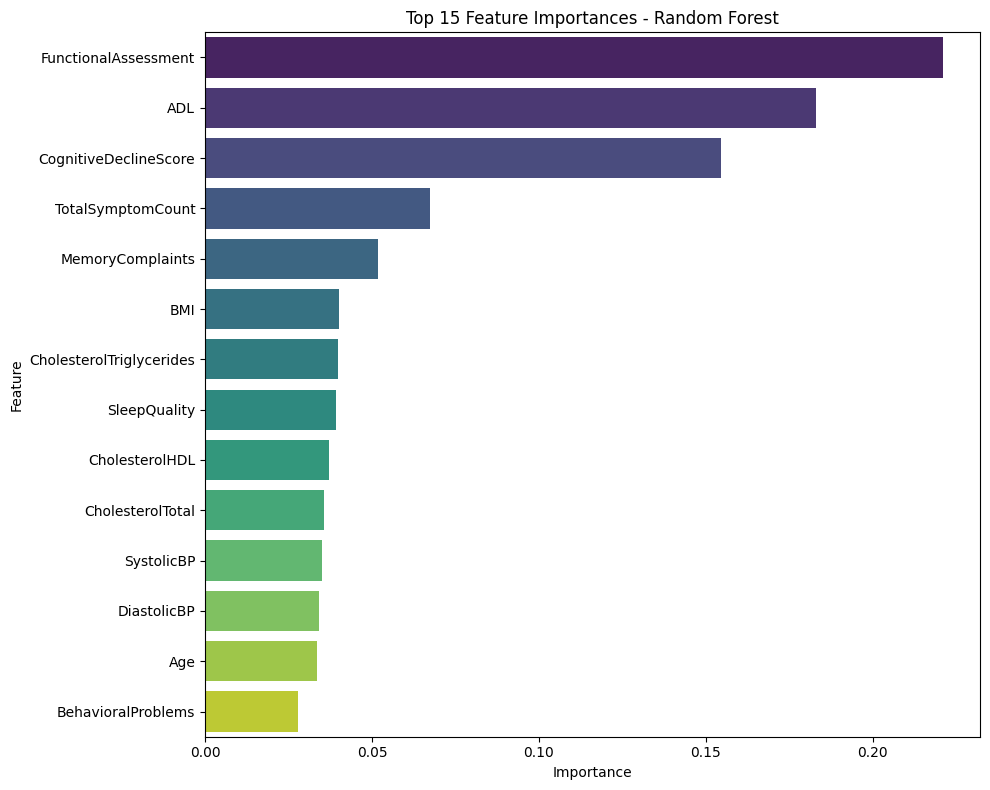

Top 10 Most Important Features:
                     Feature  Importance
8       FunctionalAssessment    0.221029
11                       ADL    0.182896
12     CognitiveDeclineScore    0.154394
13         TotalSymptomCount    0.067223
9           MemoryComplaints    0.051753
1                        BMI    0.040015
7   CholesterolTriglycerides    0.039845
2               SleepQuality    0.039361
6             CholesterolHDL    0.037136
5           CholesterolTotal    0.035518


In [35]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

## 4. Model Persistence

Saving the trained Random Forest model for future use in predictions or model comparisons. The saved model includes:
- Best hyperparameters found through GridSearchCV
- Trained ensemble of decision trees
- Feature importance rankings
- Complete model ready for production use

In [36]:
# Save model to outputs/models folder
os.makedirs('../outputs/models', exist_ok=True)
model_path = '../outputs/models/random_forest_model.pkl'
joblib.dump(best_rf, model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../outputs/models/random_forest_model.pkl


## 5. Final Results Summary

The Random Forest model performance summary for easy comparison with other models:

In [37]:
# Display final metrics for model comparison

In [38]:
# Save test predictions and metrics
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test,
    'Prediction_Probability': y_proba_test
})

# Display final metrics for model comparison
print("="*50)
print("RANDOM FOREST MODEL - FINAL PERFORMANCE SUMMARY")  
print("="*50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_test):.4f}")
print("="*50)

# Create results dataframe for display  
metrics_summary = {
    'Model': ['Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_test)],
    'Precision': [precision_score(y_test, y_pred_test)], 
    'Recall': [recall_score(y_test, y_pred_test)],
    'F1_Score': [f1_score(y_test, y_pred_test)],
    'ROC_AUC': [roc_auc_score(y_test, y_proba_test)]
}

metrics_df = pd.DataFrame(metrics_summary)
print("\nRandom Forest Results:")
print(metrics_df.round(4))

# Save results to outputs/results folder
os.makedirs('../outputs/results', exist_ok=True)
metrics_df.to_csv('../outputs/results/random_forest_metrics_summary.csv', index=False)
print(f"\n✓ Results saved to: outputs/results/random_forest_metrics_summary.csv")

RANDOM FOREST MODEL - FINAL PERFORMANCE SUMMARY
Accuracy:  0.9209
Precision: 0.9534
Recall:    0.8846
F1-Score:  0.9177
ROC-AUC:   0.9568

Random Forest Results:
           Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC
0  Random Forest    0.9209     0.9534  0.8846    0.9177   0.9568

✓ Results saved to: outputs/results/random_forest_metrics_summary.csv


In [39]:
# Get validation predictions for CSV files
y_pred = best_rf.predict(X_val)
y_pred_proba = best_rf.predict_proba(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])

# Save predictions CSV
predictions_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred,
    'Prediction_Probability': y_pred_proba[:, 1]  # Probability of positive class
})
predictions_df.to_csv('../outputs/results/random_forest_predictions.csv', index=False)

# Save validation results CSV
validation_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Value': [accuracy, precision, recall, f1, roc_auc]
})
validation_results.to_csv('../outputs/results/random_forest_validation_results.csv', index=False)

print("✅ Random Forest predictions saved to ../outputs/results/random_forest_predictions.csv")
print("✅ Random Forest validation results saved to ../outputs/results/random_forest_validation_results.csv")

✅ Random Forest predictions saved to ../outputs/results/random_forest_predictions.csv
✅ Random Forest validation results saved to ../outputs/results/random_forest_validation_results.csv
